# Classification: Quasar vs Galaxy

### WIP - Unfinished!!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import (precision_recall_curve, roc_curve, confusion_matrix, ConfusionMatrixDisplay, accuracy_score)
from sklearn.neighbors import KernelDensity, KNeighborsClassifier

import corner
from astropy.io import ascii
from tqdm import tqdm


plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['font.size'] = 12

In [2]:
data = ascii.read('../solutions/galaxyquasar.csv', header_start=0)

In [3]:
data

u,g,r,i,z,class,z1,zerr
float64,float64,float64,float64,float64,str6,float64,float64
18.97213,18.53676,18.5828,18.34936,18.29215,QSO,0.5228189,0.0001547483
19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.1228459,2.816076e-05
19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.0,0.0
19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.1474355,9.310701e-06
19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.0006307968
17.60994,15.90911,15.0209,14.54955,14.19971,GALAXY,0.04619161,1.022329e-05
18.50014,17.42286,17.03657,16.76236,16.63258,GALAXY,0.0516851,6.667251e-06
19.53253,19.49823,19.42254,19.07912,18.90426,QSO,1.88844,0.0005242734
19.37014,17.94086,17.154,16.74367,16.42825,GALAXY,0.137445,1.284492e-05


In [4]:
u_g = (data['u'] - data['g'])[:, None]
g_r = (data['g'] - data['r'])[:, None]
r_i = (data['r'] - data['i'])[:, None]
i_z = (data['i'] - data['z'])[:, None]

#Quasar = 1, Galaxy = 0
label = np.where(data['class'] == 'QSO', 1, 0)

In [14]:
feel = u_g[label == 0]
feel.shape

(42866, 1)

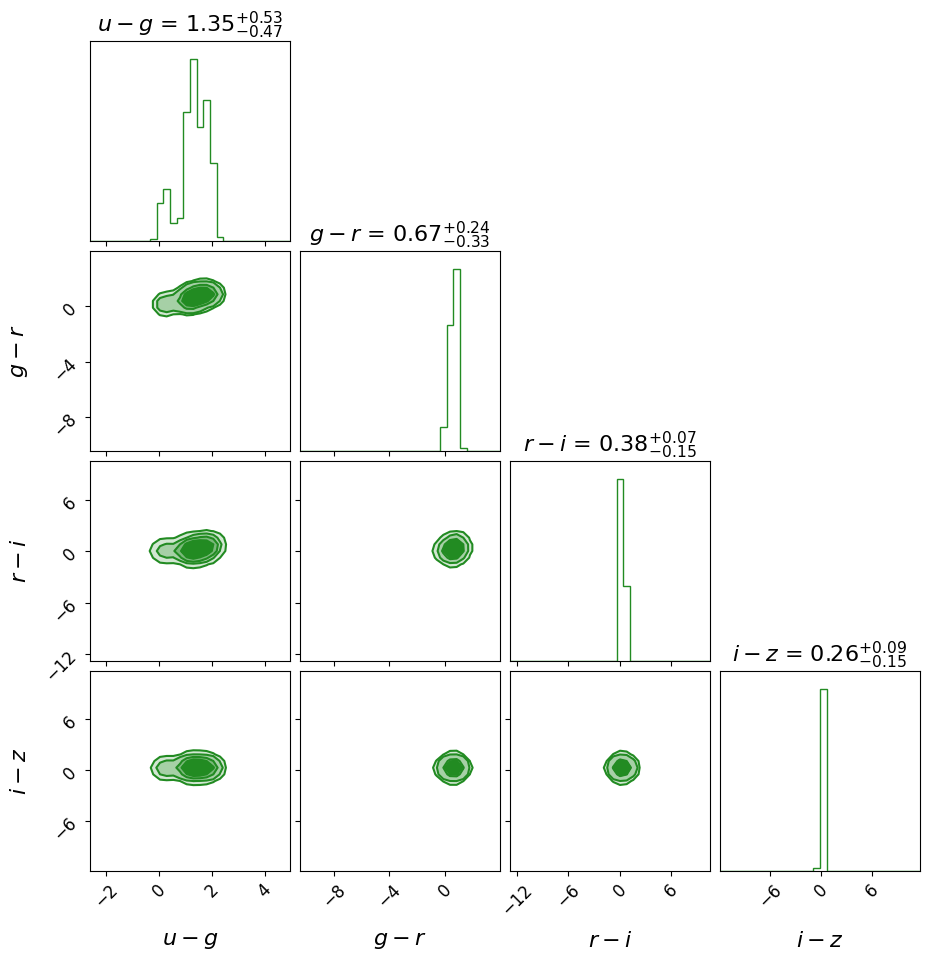

In [5]:
#Reshaping data
tofit = np.column_stack([u_g, g_r, r_i, i_z])
labels = [r"$u-g$", r"$g-r$", r"$r-i$", r"$i-z$"]

#Pretty-plotting arguments for corner plots
CORNER_KWARGS = dict(
    smooth = 1,
    label_kwargs = dict(fontsize=16),
    title_kwargs = dict(fontsize=16),
    bins = 30,
    labels = labels,
    #quantiles = [0.05, 0.50, 0.95],
    levels = [0.50, 0.68, 0.85, 0.95],
    color = 'forestgreen',
    plot_density = False,
    plot_datapoints = False,
    fill_contours = True,
    show_titles = True,
    max_n_ticks = 4
)

corner.corner(tofit, **CORNER_KWARGS);

## Classification

Best score is for k=5


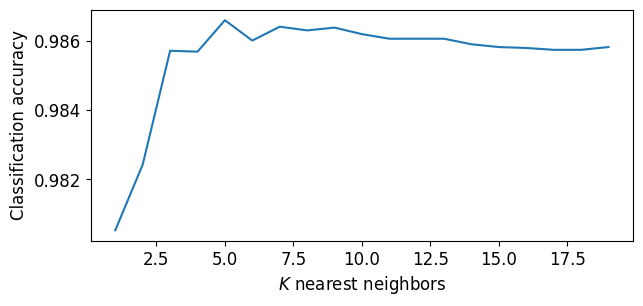

In [6]:
#Quick Cross Validation to see which value optimizes the k-neighbors classifier

size = 0.75
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(tofit, label, test_size=size)

# perform Classification
scores = []
kvals = np.arange(1,20)
for k in kvals:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(xtrain, ytrain)
    CVpredk = cross_val_predict(clf, xtest, ytest, n_jobs=-1)
    scores.append(accuracy_score(ytest, CVpredk))

scores = np.array(scores)

k_best = kvals[np.argmax(scores)]
print('Best score is for k={:d}'.format(k_best))

# Plot number of neighbors vs score
fig = plt.figure(figsize=(7, 3))
plt.plot(kvals,scores)
plt.xlabel('$K$ nearest neighbors')
plt.ylabel('Classification accuracy')
plt.show()

In [7]:
#Classifying with multiple classifiers

clfs = {
        'GNB' : GaussianNB(),                       #Gaussian Naive Bayes
        'LDA' : LDA(),                              #Linear Discriminant Analysis
        'QDA' : QDA(),                              #Quadratic Discriminant Analysis
        'KNNC' : KNeighborsClassifier(k_best)       #K-nearest neighbors classifier
        }

size = 0.75
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(tofit, label, test_size=size)

result = []

for key in clfs.keys():
    classifier = clfs[key]
    classifier.fit(xtrain, ytrain)
    result.append(classifier.predict(xtest))

result = np.array(result)

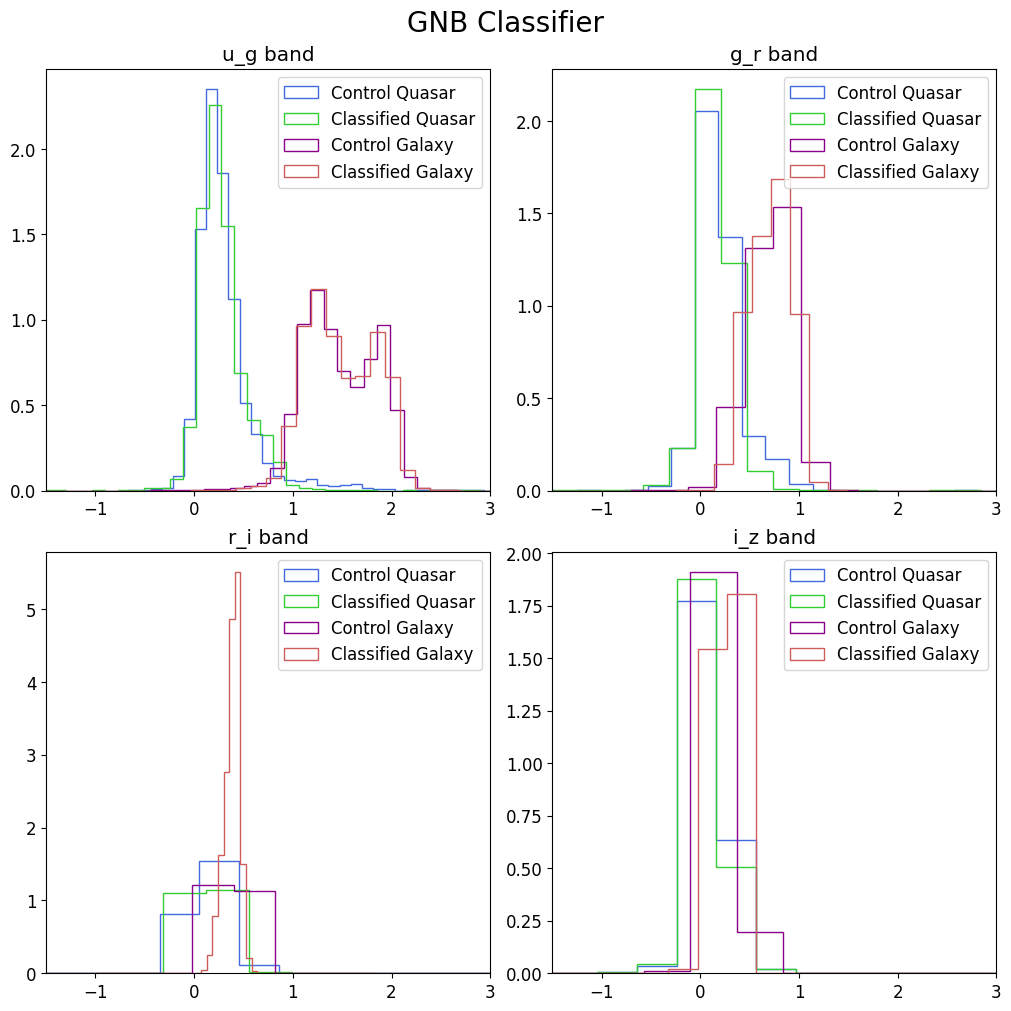

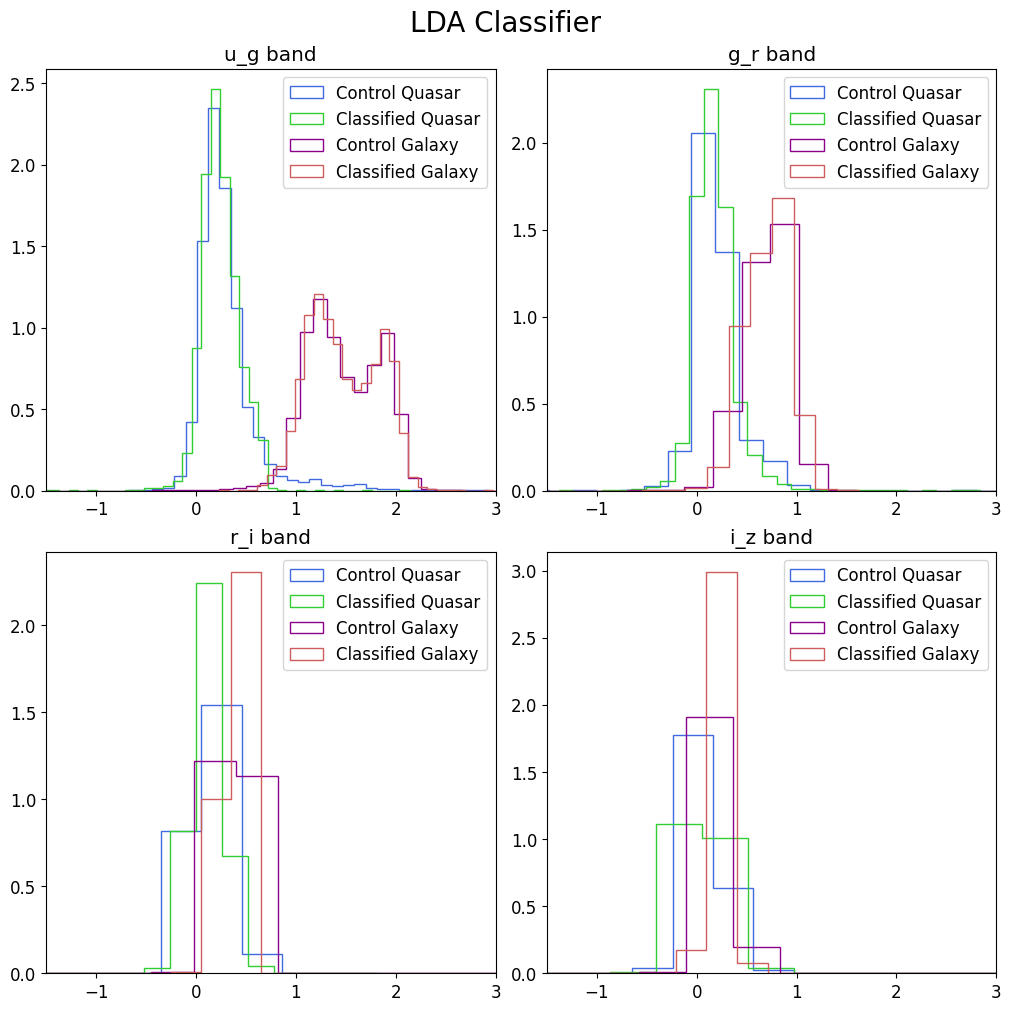

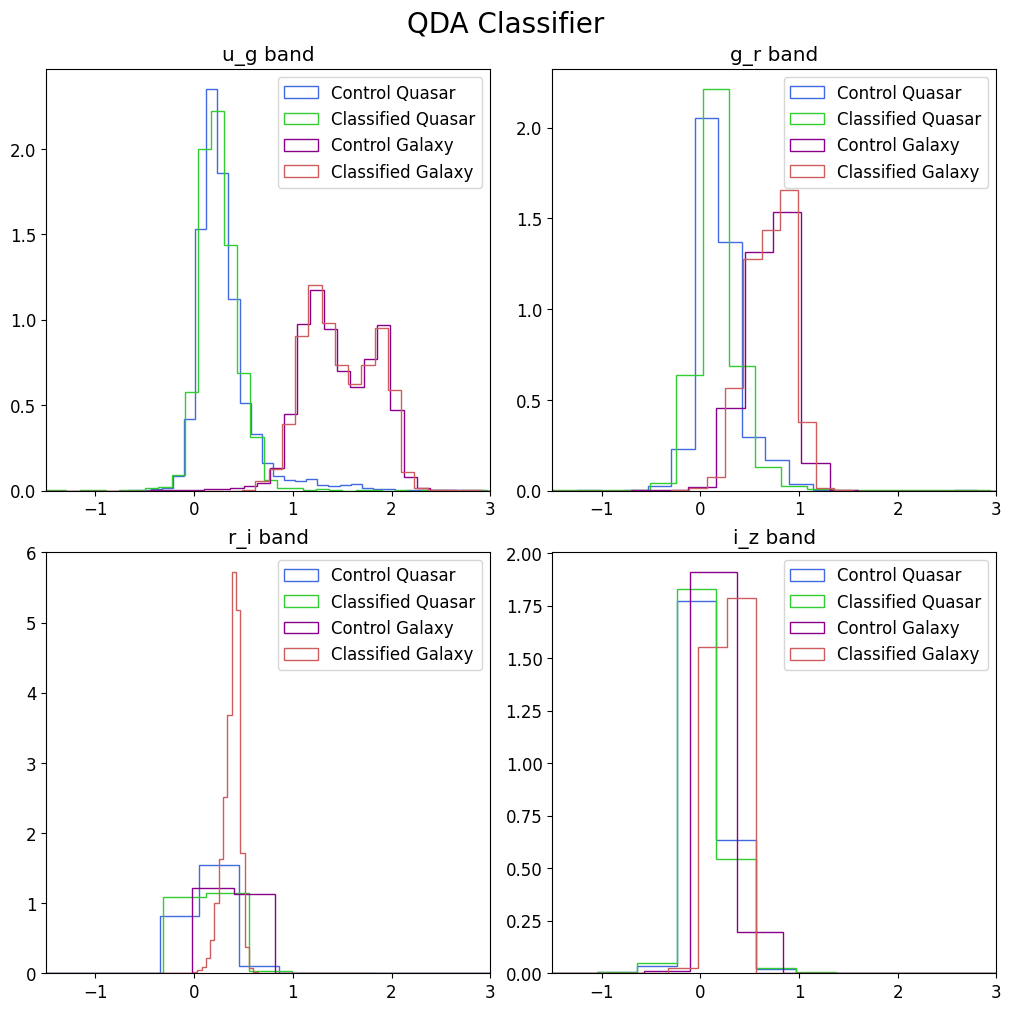

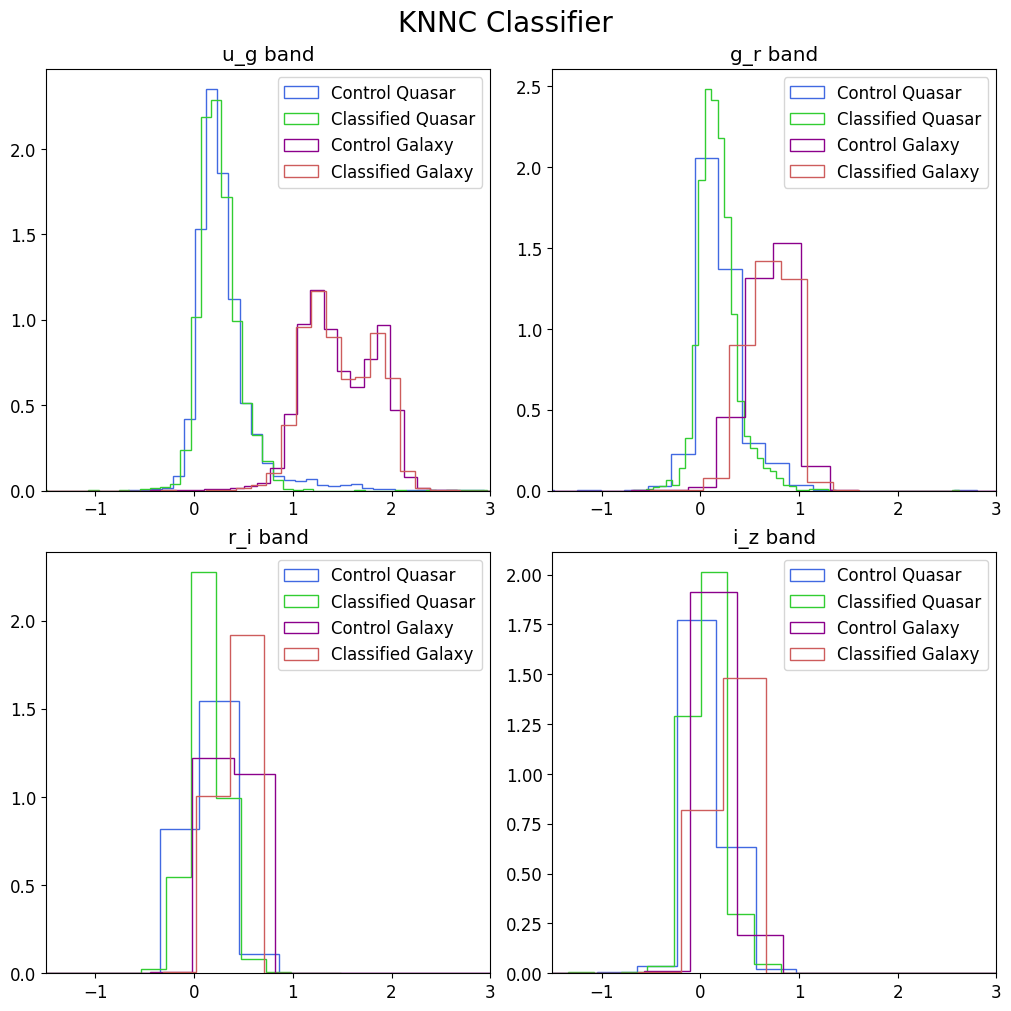

In [34]:
#Plotting

for i, key in enumerate(clfs.keys()):

    fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
    fig.suptitle(key + ' Classifier', fontsize=20)

    #Image Building

    #Top Left
    axs[0, 0].set_title('u_g band')
    axs[0, 0].hist(u_g[label == 1], bins=50, density=True, label='Control Quasar', color='royalblue', histtype='step')
    axs[0, 0].hist(xtest[:, 0][result[i] == 1], bins=50, density=True, label='Classified Quasar', color='limegreen', histtype='step')
    axs[0, 0].hist(u_g[label == 0], bins=50, density=True, label='Control Galaxy', color='darkmagenta', histtype='step')
    axs[0, 0].hist(xtest[:, 0][result[i] == 0], bins=50, density=True, label='Classified Galaxy', color='indianred', histtype='step')
    axs[0, 0].set_xlim(-1.5, 3)
    axs[0, 0].legend()

    #Top Right
    axs[0, 1].set_title('g_r band')
    axs[0, 1].hist(g_r[label == 1], bins=50, density=True, label='Control Quasar', color='royalblue', histtype='step')
    axs[0, 1].hist(xtest[:, 1][result[i] == 1], bins=50, density=True, label='Classified Quasar', color='limegreen', histtype='step')
    axs[0, 1].hist(g_r[label == 0], bins=50, density=True, label='Control Galaxy', color='darkmagenta', histtype='step')
    axs[0, 1].hist(xtest[:, 1][result[i] == 0], bins=50, density=True, label='Classified Galaxy', color='indianred', histtype='step')
    axs[0, 1].set_xlim(-1.5, 3)
    axs[0, 1].legend()

    #Bottom Left
    axs[1, 0].set_title('r_i band')
    axs[1, 0].hist(r_i[label == 1], bins=50, density=True, label='Control Quasar', color='royalblue', histtype='step')
    axs[1, 0].hist(xtest[:, 2][result[i] == 1], bins=50, density=True, label='Classified Quasar', color='limegreen', histtype='step')
    axs[1, 0].hist(r_i[label == 0], bins=50, density=True, label='Control Galaxy', color='darkmagenta', histtype='step')
    axs[1, 0].hist(xtest[:, 2][result[i] == 0], bins=50, density=True, label='Classified Galaxy', color='indianred', histtype='step')
    axs[1, 0].set_xlim(-1.5, 3)
    axs[1, 0].legend()

    #Bottom Right
    axs[1, 1].set_title('i_z band')
    axs[1, 1].hist(i_z[label == 1], bins=50, density=True, label='Control Quasar', color='royalblue', histtype='step')
    axs[1, 1].hist(xtest[:, 3][result[i] == 1], bins=50, density=True, label='Classified Quasar', color='limegreen', histtype='step')
    axs[1, 1].hist(i_z[label == 0], bins=50, density=True, label='Control Galaxy', color='darkmagenta', histtype='step')
    axs[1, 1].hist(xtest[:, 3][result[i] == 0], bins=50, density=True, label='Classified Galaxy', color='indianred', histtype='step')
    axs[1, 1].set_xlim(-1.5, 3)
    axs[1, 1].legend()

    plt.show()

## ROC CURVES AND PERFORMANCE

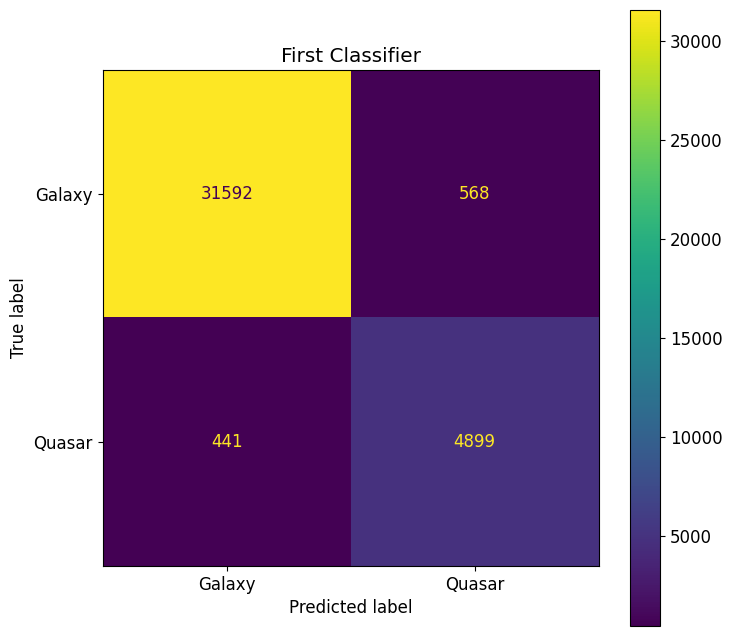

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
conf_matrix = confusion_matrix(ytest, result[0])
display = ConfusionMatrixDisplay(conf_matrix, display_labels=['Galaxy', 'Quasar']).plot(ax=ax)
display.ax_.set_title('First Classifier')
plt.show()

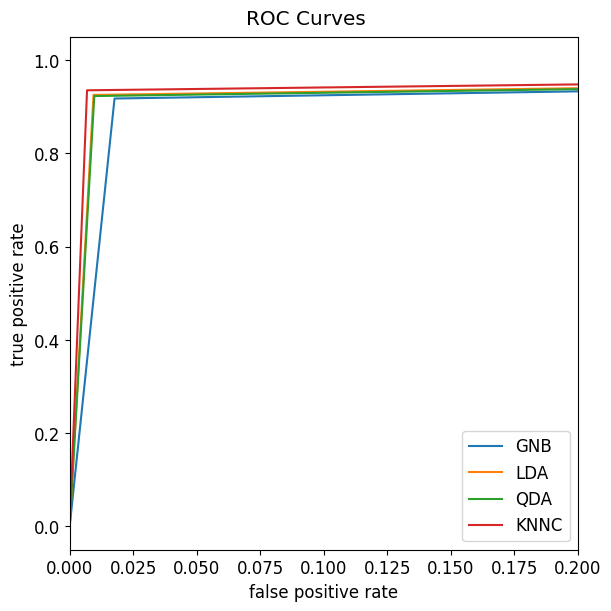

In [35]:
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)

for i, clf in enumerate(clfs.keys()):
    false_positive, true_positive, threshold = roc_curve(ytest, result[i])
    false_positive = np.concatenate([[0], false_positive])
    true_positive = np.concatenate([[0], true_positive])
    ax.plot(false_positive, true_positive, label=clf)
fig.suptitle('ROC Curves')
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_xlim(0, 0.2)
plt.legend()
plt.show()